In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = '/data/ajay/clip/nerf/nerf-pytorch/logs/112_fern_allviews_dumpdata/consistency_data.pth'

## Load dumped data

In [3]:
with torch.no_grad():
    data = torch.load(data_path, map_location='cpu')

In [4]:
for k, v in data.items():
    try:
        print(k, v.shape)
    except:
        try:
            print(k, list(map(lambda x: x.shape, v)))
        except:
            print(k)

rays [torch.Size([189, 252, 3]), torch.Size([189, 252, 3])]
rgb torch.Size([189, 252, 3])
extras
rgbs torch.Size([2, 3, 224, 224])
target torch.Size([1, 3, 224, 224])
old_target torch.Size([1, 3, 378, 504])
rendered_pose torch.Size([3, 4])
target_pose torch.Size([3, 4])
stacked_embeddings torch.Size([3, 1024])
spatial_features torch.Size([3, 256, 56, 56])
HWF


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


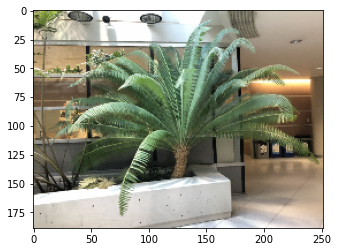

In [5]:
plt.imshow(data['rgb'].detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


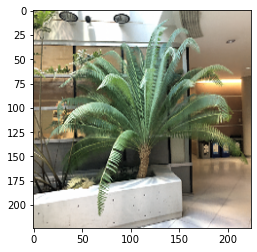

In [6]:
plt.imshow(data['rgbs'].detach()[0].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


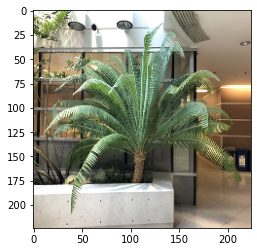

In [7]:
plt.imshow(data['target'].detach().squeeze(0).permute(1, 2, 0))

In [8]:
rgb_features, rgb0_features, target_features = data['spatial_features'].detach().float()

In [12]:
rgb_features.shape, rgb0_features.shape, target_features.shape

(torch.Size([256, 56, 56]),
 torch.Size([256, 56, 56]),
 torch.Size([256, 56, 56]))

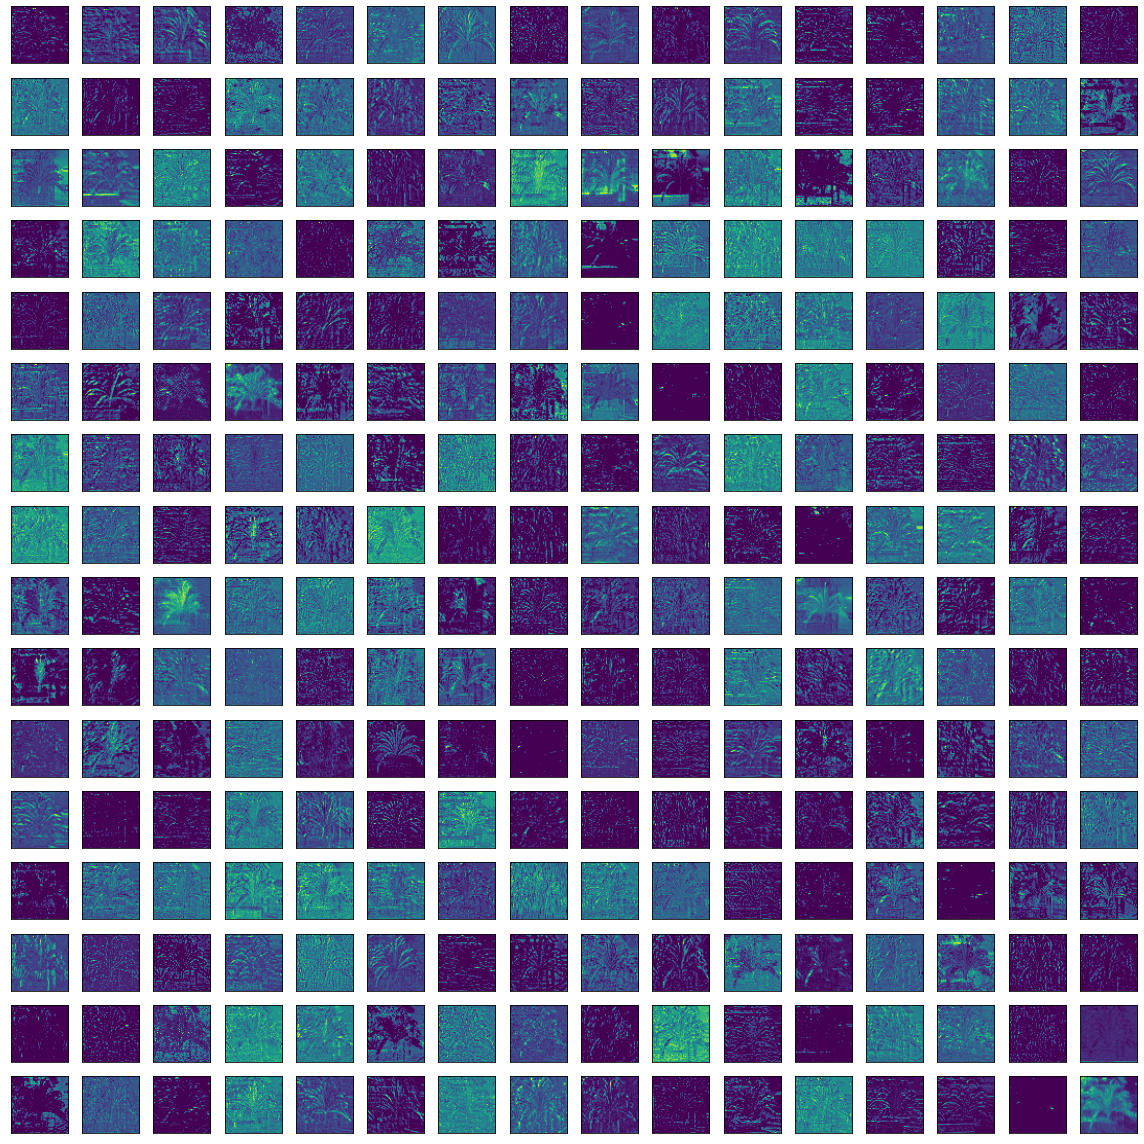

In [9]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
for r in range(16):
    for c in range(16):
        axes[r, c].imshow(target_features[r * 16 + c][:, :, None])
        axes[r, c].axes.xaxis.set_visible(False)
        axes[r, c].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

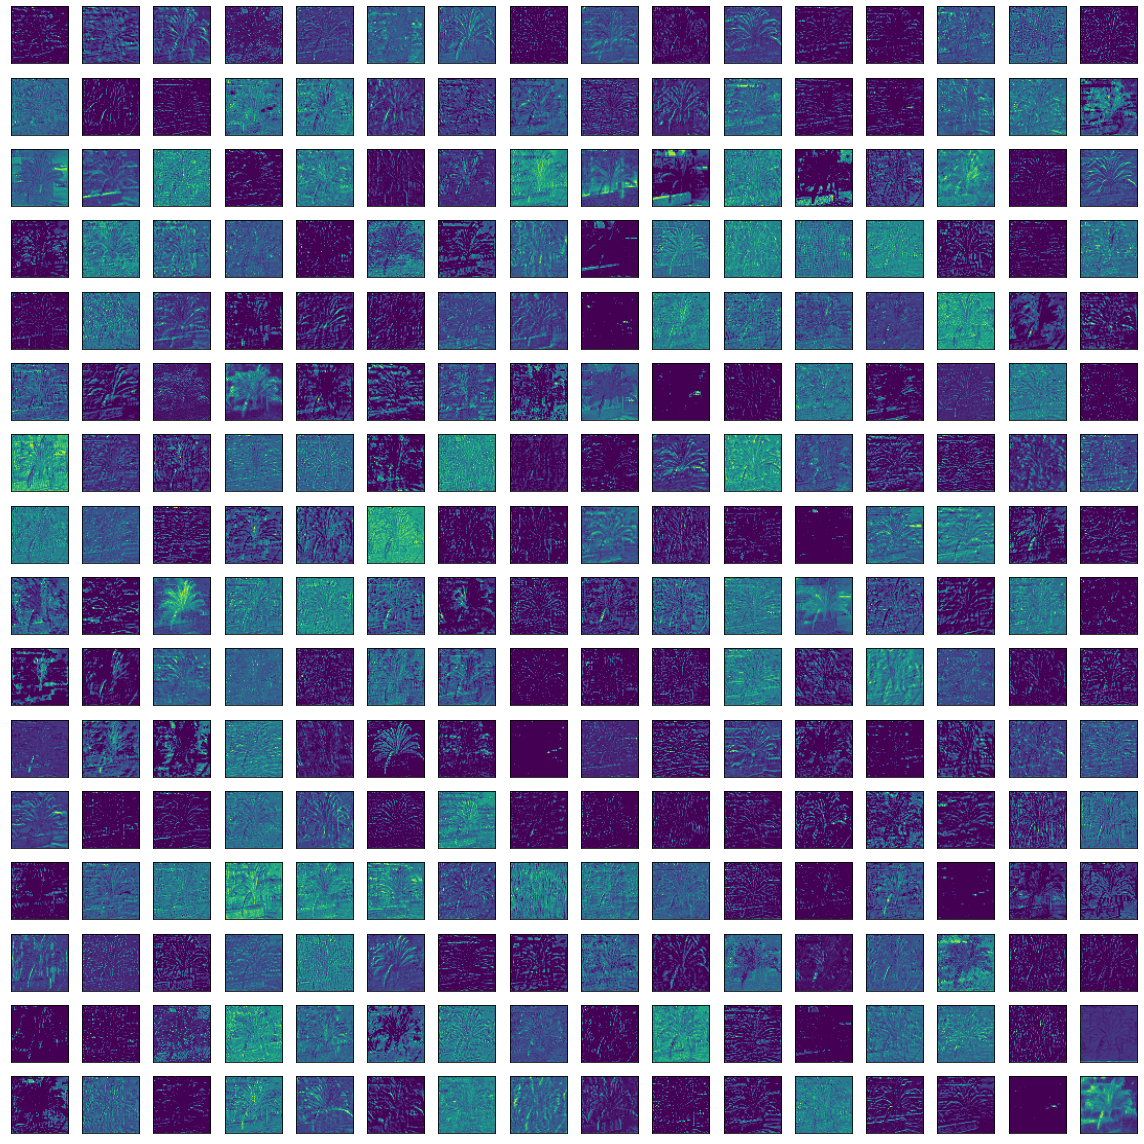

In [10]:
fig, axes = plt.subplots(16, 16, figsize=(16, 16))
for r in range(16):
    for c in range(16):
        axes[r, c].imshow(rgb_features[r * 16 + c][:, :, None])
        axes[r, c].axes.xaxis.set_visible(False)
        axes[r, c].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

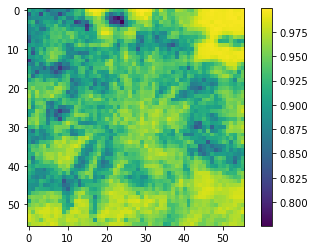

In [13]:
with torch.no_grad():
    unaligned_sim = torch.nn.functional.cosine_similarity(rgb_features, target_features, dim=0)

plt.imshow(unaligned_sim)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


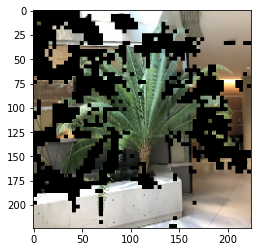

In [14]:
with torch.no_grad():
    unaligned_sim_big = torch.nn.functional.interpolate(unaligned_sim.unsqueeze(0).unsqueeze(0), size=(224, 224))
    print(data['rgbs'][0].shape)
    rgb_masked = data['rgbs'][0] * (unaligned_sim_big.squeeze(0) > 0.92)
    plt.imshow(rgb_masked.permute(1, 2, 0))

## Project rays

In [15]:
rays_o, rays_d = data['rays']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


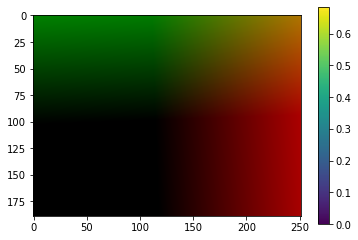

In [16]:
# plt.imshow((rays_d - rays_d.min()) / rays_d.max())
# plt.imshow((rays_d + rays_d.min(), vmax=rays_d.max())
plt.imshow(rays_d)
plt.colorbar()

In [17]:
rays_d

tensor([[[-0.5438,  0.5038, -1.0237],
         [-0.5389,  0.5036, -1.0234],
         [-0.5340,  0.5034, -1.0231],
         ...,
         [ 0.6754,  0.4611, -0.9542],
         [ 0.6803,  0.4610, -0.9539],
         [ 0.6852,  0.4608, -0.9537]],

        [[-0.5439,  0.4989, -1.0238],
         [-0.5390,  0.4987, -1.0235],
         [-0.5341,  0.4985, -1.0232],
         ...,
         [ 0.6752,  0.4562, -0.9543],
         [ 0.6801,  0.4561, -0.9540],
         [ 0.6850,  0.4559, -0.9538]],

        [[-0.5441,  0.4940, -1.0239],
         [-0.5392,  0.4938, -1.0236],
         [-0.5343,  0.4936, -1.0233],
         ...,
         [ 0.6751,  0.4513, -0.9544],
         [ 0.6800,  0.4512, -0.9541],
         [ 0.6849,  0.4510, -0.9539]],

        ...,

        [[-0.5746, -0.4082, -1.0427],
         [-0.5697, -0.4084, -1.0424],
         [-0.5648, -0.4086, -1.0421],
         ...,
         [ 0.6446, -0.4509, -0.9732],
         [ 0.6495, -0.4510, -0.9729],
         [ 0.6544, -0.4512, -0.9726]],

        [[

In [18]:
w2c_rotation = data['rendered_pose'][:, :3].T

In [20]:
data['extras'].keys()

dict_keys(['pts', 'raw', 'rgb0'])

In [24]:
data['extras']['pts'].shape

torch.Size([189, 252, 128, 3])

**Sample points along rays**

In [21]:
import sys
sys.path.append('/data/ajay/clip/nerf/nerf-pytorch/')
from run_nerf_helpers import ndc_rays

In [25]:
# # use provided ray batch
# rays_o, rays_d = data['rays']
# H,W,focal = data['HWF']
# use_viewdirs = True
# c2w_staticcam = None
# ndc = True
# near = 0.
# far = 1.

# print(rays_o.shape, rays_d.shape)

# if use_viewdirs:
#     # provide ray directions as input
#     viewdirs = rays_d
#     if c2w_staticcam is not None:
#         # special case to visualize effect of viewdirs
#         rays_o, rays_d = get_rays(H, W, focal, c2w_staticcam)
#     viewdirs = viewdirs / torch.norm(viewdirs, dim=-1, keepdim=True)
#     viewdirs = torch.reshape(viewdirs, [-1,3]).float()

# print(rays_o.shape, rays_d.shape, rays_o)
    
# sh = rays_d.shape # [..., 3]
# if ndc:
#     # for forward facing scenes
#     print('ndc')
#     rays_o, rays_d = ndc_rays(H, W, focal, 1., rays_o, rays_d)

# print(rays_o.shape, rays_d.shape, rays_o)
    
# # Create ray batch
# rays_o = torch.reshape(rays_o, [-1,3]).float()
# rays_d = torch.reshape(rays_d, [-1,3]).float()

# print(rays_o.shape, rays_d.shape)

# near, far = near * torch.ones_like(rays_d[...,:1]), far * torch.ones_like(rays_d[...,:1])

# print(near.shape, far.shape)

# rays = torch.cat([rays_o, rays_d, near, far], -1)
# if use_viewdirs:
#     rays = torch.cat([rays, viewdirs], -1)

# print(viewdirs.shape)
# print(rays.shape)

**Access raw sample data**

In [27]:
data['extras']['raw'].shape

torch.Size([189, 252, 128, 4])

In [28]:
data['extras']['pts'].shape

torch.Size([189, 252, 128, 3])

In [172]:
# TODO: change to target_pose. just trying to get a grid out...
c2w_rotation = data['target_pose'][:, :3]
camera_origin = data['target_pose'][:, 3].unsqueeze(1)
w2c = torch.cat([c2w_rotation.T, -c2w_rotation.T.mm(camera_origin)], dim=1)
w2c.shape
w2c

tensor([[ 0.9896,  0.0116, -0.1433, -0.3681],
        [-0.0064,  0.9993,  0.0367,  0.0427],
        [ 0.1436, -0.0354,  0.9890, -0.0056]])

In [173]:
rendered_pts = data['extras']['pts']
rendered_pts.shape

torch.Size([189, 252, 128, 3])

In [174]:
# plt.figure(figsize=(20, 10))
# plt.scatter(rendered_pts[:, 0], uv[:, 1], marker='.', s=4)
# rendered_pts

In [175]:
rendered_pts_extended = torch.cat([rendered_pts, torch.ones_like(rendered_pts[..., 0:1])], dim=-1)
rendered_pts_camera = torch.einsum('cw,absw->absc', w2c, rendered_pts_extended)
rendered_pts_camera.shape

torch.Size([189, 252, 128, 3])

In [179]:
uv = -rendered_pts_camera[..., :2] / rendered_pts_camera[..., 2:]  # [H,W,B,2]
# uv = -data['HWF'][2] * rendered_pts_camera[..., :2] / rendered_pts_camera[..., 2:]  # [H,W,B,2]
# uv = -data['HWF'][2] * rendered_pts[..., :2]# / rendered_pts[..., 2:]  # [H,W,B,2]

# uv = -xyz[:, :, :2] / xyz[:, :, 2:]  # (SB, B, 2)
# uv *= repeat_interleave(
#     self.focal.unsqueeze(1), NS if self.focal.shape[0] > 1 else 1
# )
# uv += repeat_interleave(
#     self.c.unsqueeze(1), NS if self.c.shape[0] > 1 else 1
# )  # (SB*NS, B, 2)

In [180]:
uv.shape

torch.Size([189, 252, 128, 2])

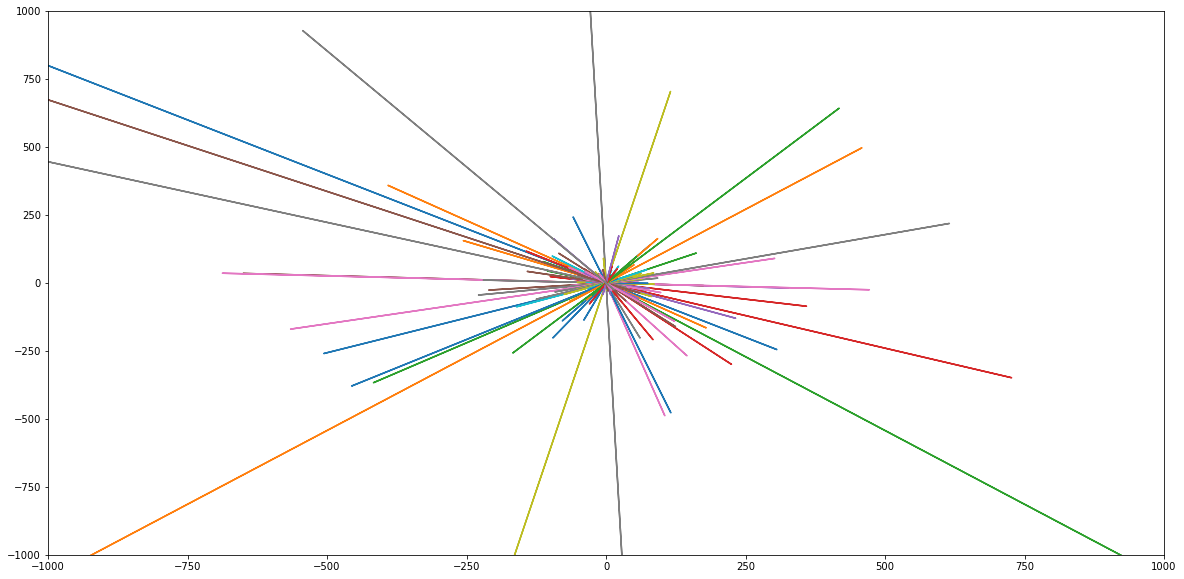

In [181]:
plt.figure(figsize=(20, 10))
# plt.scatter(rendered_pts[:10, :10, ..., 0], rendered_pts[:10, :10, ..., 1], marker='.', s=4, c=rendered_pts[:10, :10, ..., 2])
# plt.scatter(rendered_pts_camera[:10, :10, ..., 0], rendered_pts_camera[:10, :10, ..., 1], marker='.', s=4, c=rendered_pts_camera[:10, :10, ..., 2])
# plt.scatter(rendered_pts_camera[:10, :10, :, 0].reshape(-1, 128),
#          rendered_pts_camera[:10, :10, :, 1].reshape(-1, 128), marker='.', s=4,
#          c=rendered_pts_camera[:10, :10, :, 2].reshape(-1, 128))

# color = rendered_pts_camera[:2, :2, :, 2].reshape(-1, 128).T
# color = color - color.min()
# color = color / color.max()
# plt.plot(rendered_pts_camera[:20, :20, :, 0].reshape(-1, 128).T,
#          rendered_pts_camera[:20, :20, :, 1].reshape(-1, 128).T)

plt.plot(uv[::24, ::24, :, 0].reshape(-1, 128).T,
         uv[::24, ::24, :, 1].reshape(-1, 128).T)
#          color=torch.stack((color, color, color), dim=2))
# plt.colorbar()
# plt.scatter(uv[..., 0], uv[..., 1], marker='.', s=4)
# plt.plot(rays_o[:, 0], rays_o[:, 1], linewidth=1)
plt.ylim([-1000, 1000])
plt.xlim([-1000, 1000])
plt.show()

(-0.157, -0.154)

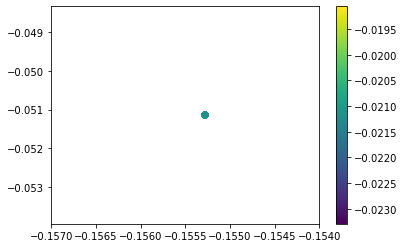

In [193]:
plt.scatter(data['rays'][0][..., 0], data['rays'][0][..., 1], c=data['rays'][0][..., 2])
plt.colorbar()
plt.xlim([-.157, -.154])

In [165]:
rendered_pts_camera[..., 2:]

tensor([[[[-0.9324],
          [-0.9151],
          [-0.8766],
          ...,
          [ 0.9902],
          [ 1.0010],
          [ 1.0341]],

         [[-0.9263],
          [-0.9137],
          [-0.8926],
          ...,
          [ 0.9818],
          [ 0.9923],
          [ 1.0348]],

         [[-0.9308],
          [-0.9129],
          [-0.8786],
          ...,
          [ 0.9901],
          [ 0.9985],
          [ 1.0341]],

         ...,

         [[-1.0434],
          [-1.0203],
          [-0.9772],
          ...,
          [ 0.8615],
          [ 0.8867],
          [ 0.9134]],

         [[-1.0530],
          [-1.0339],
          [-0.9848],
          ...,
          [ 0.8492],
          [ 0.8967],
          [ 0.9216]],

         [[-1.0415],
          [-1.0286],
          [-0.9994],
          ...,
          [ 0.8481],
          [ 0.9040],
          [ 0.9218]]],


        [[[-0.9298],
          [-0.9151],
          [-0.8753],
          ...,
          [ 0.9652],
          [ 1.0099],
     

In [125]:
color.shape

torch.Size([128, 4])

In [112]:
rendered_pts_camera[:2, :2, :, 0].reshape(-1, 128).shape

torch.Size([4, 128])